# Machine Learning for Textual Data - The Bible and other religious texts
<b> Advanced Numberical Methods and Data Analysis - University of St. Gallen (HSG) - Spring semester 2019 </b>

Elisa Fleissner       (14-350-608)

Lars Stauffenegger    (tbd)

Alexander Steeb       (tbd)

05.05.2019

--------------------------------------------------------------------------------------------

## Project plan and structure

In this project we analyse the bible text and other religious texts using machine learning for textual data. From this analysis we expect to see different relevant topics and contexts between the books of the bible and between the different religious texts.

This analysis is structures as follows: In a first step, a thorough analysis of the bible is done to understand different topics within the books and to see a development of the topics over time. We expect to see that certain topics where clearly more relevant in the old testament and the new testament. For the topic analysis in this section, we will use the Latent Dirichlet Allocation (LDA) and the Word2Vec algorithm is used to understand the context of certain words. This allows to capture differences in the perception of one specific word in the old. vs new testament.
In a second part we will then include other religious texts such as the Qu'aran and others. We will perform an anlysis over **five** texts to find similarities and patterns ...

### PART I: The Bible ###
- Before starting with the analysis and data import, we need to first setup helpers function and import all relevant libraries used for this project. 
- Then we are importing the data and assigning the correct names of the books to the texts as well as the testament (old or new). 
- We then have to process the data to make it suitable for the machine learning algorithm. We achieve this by defining several formulas including preprocessing, stopword removal, tokenization, lemmatization and stemming.
- When the data is ready, the actual analysis can be performed

### PART II: 5 religious texts ###
- The imported functions and cleaning steps can be used from PART I, however, we need to import all texts and bring them to the same format (i.e. no separation between the different books)
- Cleaning of the data using the functions from PART I
- Analysis

In [1]:
import sys
print(sys.executable)
print(sys.version)

/anaconda3/bin/python
3.7.1 (default, Dec 14 2018, 13:28:58) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


# PART I: The Bible

## 0. Setup

In [60]:
# import functions
import json
import os
import shutil

import requests, zipfile, io

import pandas as pd

import re


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob, Word

import nltk
from nltk.probability import FreqDist
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
#from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
#from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import NMF, LatentDirichletAllocation

from collections import Counter

import word2vec
#import lda2vec
# error message even though I installed it.

# Option to display whole text and not only first few words
pd.set_option('display.max_colwidth', -1)


Important to install textblob correctly and to download the corpora

Source: https://textblob.readthedocs.io/en/dev/

$ pip install -U textblob
$ python -m textblob.download_corpora

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/elisafleissner/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# Helper functions

# based on: https://stackoverflow.com/questions/303200/how-do-i-remove-delete-a-folder-that-is-not-empty-with-python
def remove_folder(path):
    # check if folder exists
    if os.path.exists(path):
         # remove if exists
         shutil.rmtree(path)
    else:
         # throw your exception to handle this special scenario
         print('Folder does not exist')

## 1. Data import

In this section we will import the bible data. Particular caution has to be paid to the correct specification of the different books and the old/new testamnet as this is crucial for the following LDA analysis.

Data source: https://sites.google.com/site/ruwach/bibletext

In [6]:
remove_folder("data")

In [7]:
old_zip_file_url = "https://sites.google.com/site/ruwach/Basic_English_OldTestament.zip?attredirects=0"

#old_zip_file_url = "http://ruwach.googlepages.com/OldTestament.zip"

new_zip_file_url = "https://sites.google.com/site/ruwach/Basic_English_NewTestament.zip?attredirects=0"
#new_zip_file_url = "http://ruwach.googlepages.com/NewTestament.zip"
    
def unzip(url):
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall("data/")
    
unzip(old_zip_file_url)
unzip(new_zip_file_url)

In [15]:
path = "data"
df = pd.DataFrame()  


testaments = os.listdir(path)

for testament in testaments:
    testament_path = os.path.join(path,testament)
    books = os.listdir(testament_path)
    print(testament) #do we need this?
    
    for book in books:
        book_path = os.path.join(testament_path,book)
        files = os.listdir(book_path)    
            
        for file in files:
            file_path = os.path.join(book_path,file) 
            
            with open(file_path,"r", encoding="utf-8") as infile:
                text = infile.read()
                df = df.append([[text, testament, book, file, file_path]], ignore_index=True)
                
df.columns = ["text", "testament", "book", "file", "path"]

Old Testament
New Testament


In [16]:
books = (
    "Genesis",
    "Exodus",
    "Leviticus",
    "Numbers",
    "Deuteronomy",
    "Joshua",
    "Judges",
    "Ruth",
    "1 Samuel",
    "2 Samuel",
    "1 Kings",
    "2 Kings",
    "1 Chronicles",
    "2 Chronicles",
    "Ezra",
    "Nehemiah",
    "Esther",
    "Job",
    "Psalms",
    "Proverbs",
    "Ecclesiastes",
    "Song of Solomon",
    "Isaiah",
    "Jeremiah",
    "Lamentations",
    "Ezekiel",
    "Daniel",
    "Hosea",
    "Joel",
    "Amos",
    "Obadiah",
    "Jonah",
    "Micah",
    "Nahum",
    "Habbakuk",
    "Zephaniah",
    "Haggai",
    "Zechariah",
    "Malachi",
    "Matthew",
    "Mark",
    "Luke",
    "John",
    "Acts",
    "Romans",
    "1 Corinthians",
    "2 Corinthians",
    "Galatians",
    "Ephesians",
    "Philippians",
    "Colossians",
    "1 Thessalonians",
    "2 Thessalonians",
    "1 Timothy",
    "2 Timothy",
    "Titus",
    "Philemon",
    "Hebrews",
    "James",
    "1-2 Peter",
    "1-3 John",
    "Jude",
    "Revalation")

In [17]:
books_order = pd.DataFrame.from_records(zip(books, range(1,len(books))))

books_order.columns = ["book", "order"]

df = pd.merge(df,books_order, on ='book')

In [18]:
def get_num(text):
    return(int(''.join([n for n in text if n.isdigit()])))

df['file'] = df['file'].apply(get_num)

In [19]:
df = df.sort_values(["order","file"], ascending = [True,True])
df.reset_index(drop = True, inplace = True)

## 2. Data cleaning

In this section we will prepare the data to be analysed. We therefore need to apply different techniques to clean the data so that machine learning algorithms can analyse the data set. For a first inspection of the data, we will use a wordcloud and word count analysis.

The following steps are part of the preprocessing phase to make the text ready for the algorithms (https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34)

**Steps:** 
1. Remove blank rows in Data, if any
2. Change all the text to lower case
3. Word Tokenization
4. Remove Stop words
5. Remove Non-alpha text
6. Word Lemmatization (rather than stemming)

In [20]:
def preprocessor(t):
    '''Prepare text from TextBlob'''
    t = t.lower() 
    t = t.replace('“', '') # Quotes cause issues because they 'combine sentences'
    t = t.replace('”', '')
    t = t.replace('_', '') # Underscores signify italicization, remove them.
    t = t.replace('\n', '') # Replace newline with space
    t = re.sub('[\d]', '', t) # Replace newline with space    
    t = re.sub('[^a-zA-Z0-9 .]','',t)
    return t.strip()


# inspired by https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
def lemmatizer(text):
    text = TextBlob(text)
    tag_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}

    result = TextBlob(' ')
    
    for sentence in text.sentences:
        words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sentence.tags]
        lemmatized_list = [w.lemmatize(tag) for w, tag in words_and_tags]
        
        sentence_new = ' '.join(lemmatized_list)
        
        result = result + sentence_new + ' . '
    
    return(str(result))

# source: https://stackoverflow.com/questions/5486337/how-to-remove-stop-words-using-nltk-or-python
def remove_stopwords(text):
    text = TextBlob(text)
    text = (word for word in text.words if word not in stopwords.words('english'))
    stopremoved = ' '.join(text)
    return(str(stopremoved))


def wordcloud_map(text_corp):
    full_text = ''
    for text in text_corp:
        full_text += text    
        
    wordcloud = WordCloud(max_font_size = 40,background_color = "white").generate(full_text)

    plt.figure(figsize = (10,10))
    plt.imshow(wordcloud, interpolation = "bilinear")
    plt.axis("off")
    plt.show()

In [21]:
%%time
df['clean'] = df['text']
df['clean'] = df['clean'].apply(preprocessor)
df['clean'] = df['clean'].apply(lemmatizer)

CPU times: user 54.8 s, sys: 1.01 s, total: 55.8 s
Wall time: 56.4 s


In [22]:
%%time
df['clean_rm'] = df['clean'].apply(remove_stopwords)

CPU times: user 2min 10s, sys: 25.8 s, total: 2min 35s
Wall time: 2min 36s


## 3. Data inspection
In this section we will conduct some simple analysis of the processed data to better understand the most frequent words. We will use a wordcloud ...

### Wordcloud

The wordcloud is used to display the frequency of the words by size. This is a suitable tool for to get a first glimpse of the texts to be analysed.

We conduct this analysis for
- the entire bible
- the old testament
- the new testament

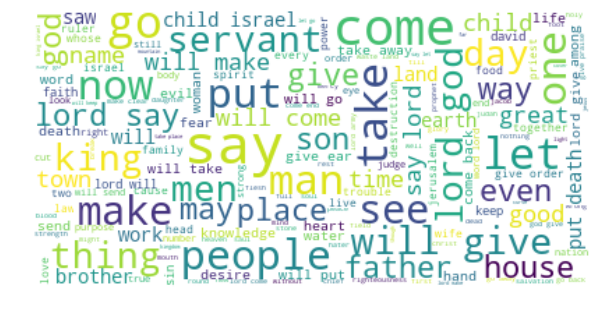

In [25]:
# Entire bible
wordcloud_map(df['clean'])

Old Testament


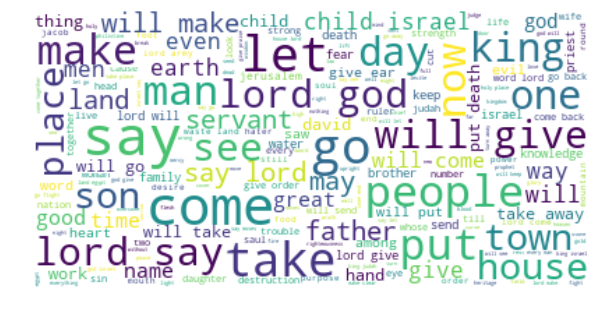

In [26]:
# Old testament only
i = 0
print(testaments[i])

data = df.loc[df.testament == testaments[i],'clean']
wordcloud_map(data)

New Testament


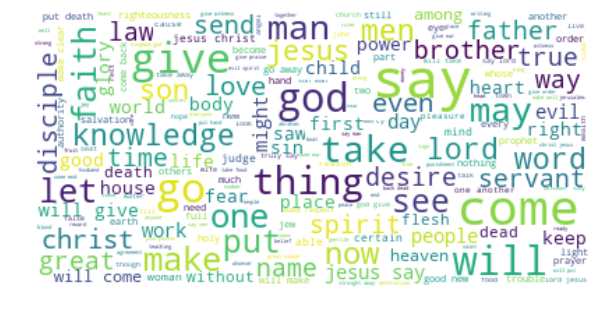

In [27]:
# New testament only
i = 1
print(testaments[i])

data = df.loc[df.testament == testaments[i],'clean']
wordcloud_map(data)

### TF-IDF analysis
In this analysis we will primarily focus on the most relevant words based on the term frequency and inverse document function.

**TODO**

- Wieviele Wörter sind es insgesamt etc.
- Welche Wörter kommen am häufigsten vor im alten/ neune Testament etc.
--> Etwas stimmt nicht mit dem wordcount, weil nur einzelne buchstaben gezählt werden...
- Plotten wo welche Wörter im Verlauf des gesamten Textes vorkommen

In [61]:
# Obtain text
text = df['clean_rm']

# Use the sklearn vectorizer
tf = TfidfVectorizer(#max_features = 10_000, 
                     min_df = 3,
                     analyzer = 'word',
                     ngram_range = (1,1))

txt_fitted = tf.fit(text)
txt_transformed = txt_fitted.transform(text)

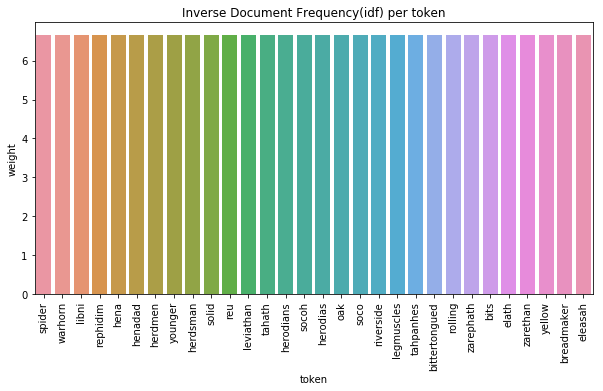

In [62]:
idf = tf.idf_
rr = dict(zip(txt_fitted.get_feature_names(), idf))

token_weight = pd.DataFrame.from_dict(rr, orient = 'index').reset_index()
token_weight.columns = ('token','weight')
token_weight = token_weight.sort_values(by = 'weight', ascending = False)
token_weight = token_weight[0:30]

sns.barplot(x = 'token', y = 'weight', data = token_weight)            
plt.title("Inverse Document Frequency(idf) per token")
fig = plt.gcf()
fig.set_size_inches(10,5)
plt.xticks(rotation = 90)
plt.show()

### Term frequency
In this analysis we will compare the word frequency of the entire bible to the old and new testament.

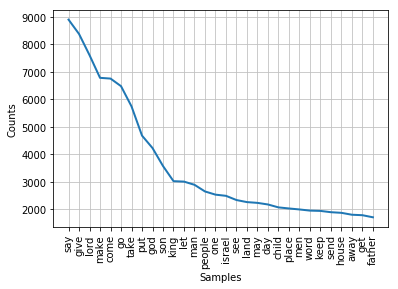

In [83]:
# Entire bible

# Use cleaned text
text = df["clean_rm"]

# Merge all books into one string
full_text = ''
for words in text:
    full_text += words
    
# Split the string into words
words = full_text.split()

# Define minimum length
len([words for words in words if len(words) > 5])

# Calculate and plot the word frequency
fd = nltk.FreqDist(words)
fd.plot(30, cumulative = False)

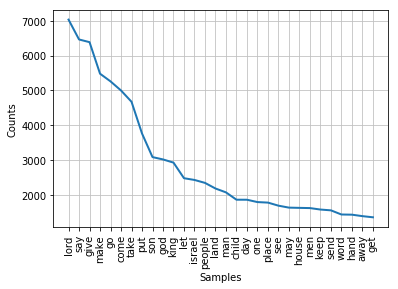

In [84]:
# Old testament

# Use cleaned text
text = df.loc[df.testament == "Old Testament", "clean_rm"]

# Merge all books into one string
full_text = ''
for words in text:
    full_text += words
    
# Split the string into words
words = full_text.split()

# Define minimum length
len([words for words in words if len(words) > 5])

# Calculate and plot the word frequency
fd = nltk.FreqDist(words)
fd.plot(30, cumulative = False)

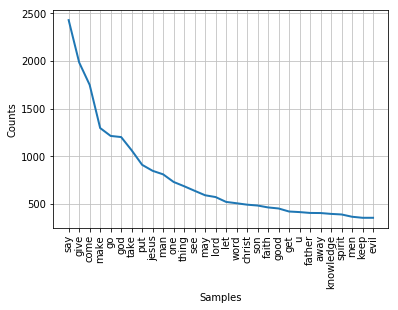

In [86]:
# New testament

# Use cleaned text
text = df.loc[df.testament == "New Testament", "clean_rm"]

# Merge all books into one string
full_text = ''
for words in text:
    full_text += words
    
# Split the string into words
words = full_text.split()

# Define minimum length
len([words for words in words if len(words) > 5])

# Calculate and plot the word frequency
fd = nltk.FreqDist(words)
fd.plot(30, cumulative = False)

## 4. Model 1 - LDA

**TODO**

- Description of what is going on
Latent Dirichlet Allocation (LDA) is a method to identify topics within a text corpus.
We will use this method for a preliminary analysis on our bible texts to see whether the topics discussed in the books have been changing over time.
We got inspiration for this code from Knoepfl, Rieger & Sommer (2018).
- **Code abändern und kommentieren, damit er nicht 1:1 wie das beispiel ist**
- Können wir das preprocessing noch verbessern? (Die top wörter der topics enthalten teilweise noch Füllwörter)
- Können wir die Top Wörter der einzelnen Topics als Wordclouds darstellen? (Das könnte glaub ein cooles extra sein)
- Können wir unsere Daten noch mit irgendwas anreichern?

In [21]:
# Options:
n_components = 4

New Testament
The ten most important words of four topics are:

Topic 1:
say go son put lord let people day god father man offering one get house land israel death away men see priest may place jesus child hand back brother name


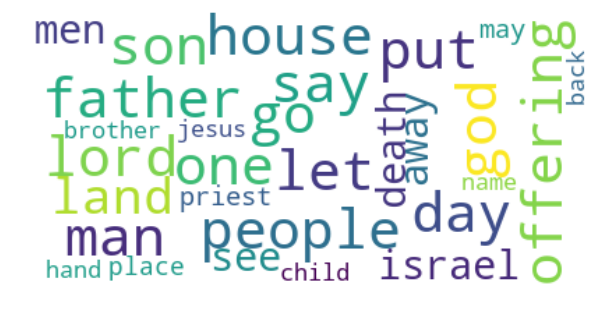


Topic 2:
lord child son go israel land say moses put people child israel god family hundred lord god place town lord say tent may holy thousand order day one every aaron father heritage priest


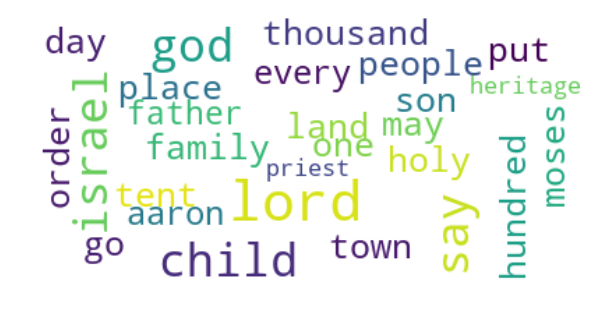


Topic 3:
lord say god go put man let see word one may keep like thing evil way good day people heart away send men great earth hand knowledge place get even


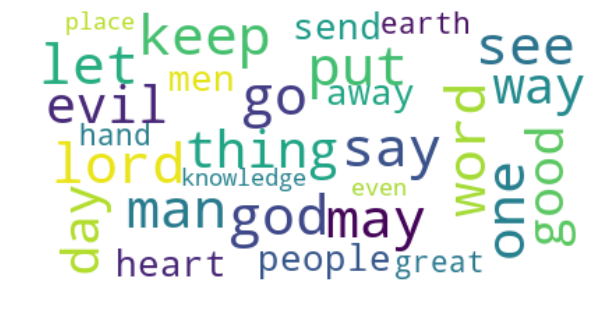


Topic 4:
king say lord go put david israel son house judah send people god jerusalem place servant men town word one get year death great back solomon father away day land


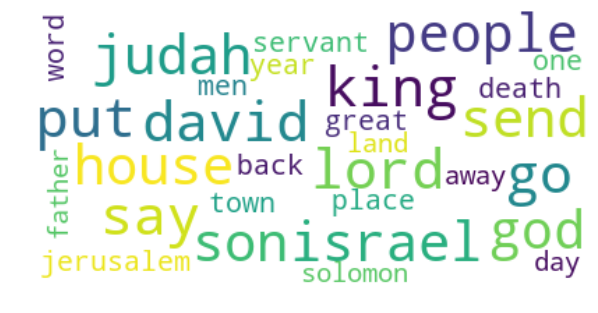

In [22]:
# Transformation into feature vectors that count how often words appear in different speeches
count = CountVectorizer(
#            max_df = 0.9,
            min_df = 2,
#            max_features = 100_000,
            ngram_range = (1,2)
            )

# For testament in testaments:
#    text = df.loc[df['testament'] == testament,"cleaned"]
text = df.loc[:,'clean_rm']
X = count.fit_transform(text)  #sparse matrix

# Fit LDA model
lda = LatentDirichletAllocation(n_components = n_components, random_state = 1000, learning_method = 'batch')

X_topics = lda.fit_transform(X)
#X_topics = nmf.fit_transform(X)

lda.components_.shape

# Print most important words of every topic
print(testament)
print("The ten most important words of four topics are:")
print()
n_top_words = 30
feature_names = count.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
    print("Topic %d:" % (topic_idx + 1))
    print(" ".join([feature_names[i]
    for i in topic.argsort()\
        [:-n_top_words - 1:-1]]))
    
    data = " ".join([feature_names[i]
    for i in topic.argsort()\
        [:-n_top_words - 1:-1]])
    wordcloud_map(data)
    
    print()
print()

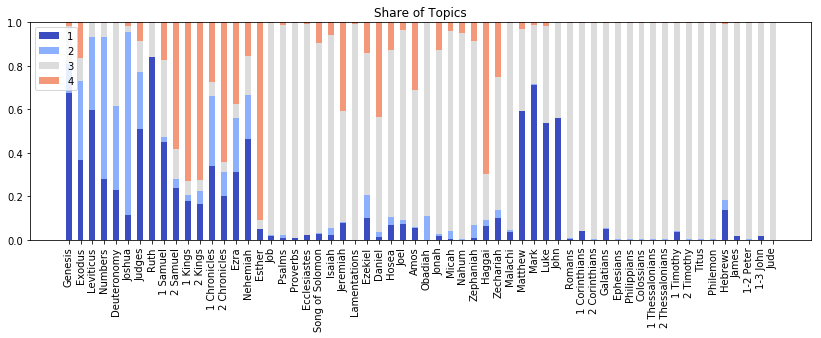

In [23]:
pset = set()  # Set of all books
plist = []
for p in df['book']:
    if p not in pset:
        plist.append(p)
        pset.add(p)

weights = []  # Take the average over all books
for p in plist:
    line = []
    indices = df.index[df['book'] == p]
    for i in indices:
        line.append(list(X_topics[i]))
    weights.append(list(np.mean(line, axis = 0)))

# #Stacked Bar plot
# Prepare plot - inspiration and code examples from https://de.dariah.eu/tatom/topic_model_visualization.html
N, K = len(weights), len(weights[0])
ind = np.arange(N)
width = 0.5 
plots = []
height_cumulative = np.zeros(N)

s = []
for x in range(K):
    t = []
    for entry in weights:
        t.append(entry[x])
    s.append(t)
    
fig = plt.figure(figsize = (14,4))
for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, s[k], width, color = color)
    else:
        p = plt.bar(ind, s[k], width, bottom = height_cumulative, color = color)
    height_cumulative += s[k]
    plots.append(p)

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.title('Share of Topics')
plt.xticks(rotation=90)
plt.xticks(ind , plist)
  
titles = []
for i in range(0,n_components):
    titles.append(i + 1)

plt.legend(titles,loc = 2)
print()

## 5. Model 2 - Word2vec

**TODO**

- Mehr insights erstellen (siehe link)
The word2vec method allows to reconstruct linguistic features of the corpus analysed and embedds the words in their context using a shallow two-layer network. This method allows to evaluate the associations to a certain word and thus allows to capture the sentiment of the text.

- z.B. was wird mit Gott im alten vs neune Testament verbunden etc. / Gott steht zu Jesus im Verhältnis wie ....
- Visualization of results

Source:
https://nbviewer.jupyter.org/github/danielfrg/word2vec/blob/master/examples/word2vec.ipynb

In [35]:
remove_folder("model")
os.mkdir("model")

In [43]:
def full_text(text):
    full_text = ''
    for text_part in text: full_text += text_part   
    return(full_text)

In [47]:
with open("model/text_full.txt", "w") as text_file:
    text_file.write(full_text(df.loc[:,'clean']))
    
with open("model/text_old.txt", "w") as text_file:
    text_file.write(full_text(df.loc[df['testament'] == testaments[0],'clean']))

with open("model/text_new.txt", "w") as text_file:
    text_file.write(full_text(df.loc[df['testament'] == testaments[1],'clean']))

In [53]:
def estimate_word2vec(file):
    word2vec.word2phrase(train = file, 
                     output="model/text-phrases", 
                     min_count=1,
                     verbose=True)
    word2vec.word2vec("model/text-phrases", "model/text.bin", 
                  size=100, 
                  min_count=2,
#                  sample=1e-5, # Downsample high frequenzy words
                  verbose=True)
    return(word2vec.load('model/text.bin'))

In [54]:
## Predictions

In [55]:
print("Fit full model")
model_full = estimate_word2vec('model/text_full.txt')

print('\n')
print("Fit old testament model")
model_old = estimate_word2vec('model/text_old.txt')

print('\n')
print("Fit new testament model")
model_new = estimate_word2vec('model/text_new.txt')

Fit full model
Starting training using file model/text_full.txt
Words processed: 800K     Vocab size: 89K  
Vocab size (unigrams + bigrams): 91734
Words in train file: 824297
Starting training using file model/text-phrases
Vocab size: 5046
Words in train file: 806143
Alpha: 0.000002  Progress: 101.02%  Words/thread/sec: 473.40k  read/sec: 448.34k  Progress: 28.03%  Words/thread/sec: 469.15k  9.23k  29%  Words/thread/sec: 469.77k  rds/thread/sec: 470.09k  : 0.003881  Progress: 84.74%  Words/thread/sec: 471.33k  

Fit old testament model
Starting training using file model/text_old.txt
Words processed: 600K     Vocab size: 76K  
Vocab size (unigrams + bigrams): 80112
Words in train file: 657233
Starting training using file model/text-phrases
Vocab size: 4648
Words in train file: 642158
Alpha: 0.000002  Progress: 101.12%  Words/thread/sec: 474.96k   0.017970  Progress: 28.44%  Words/thread/sec: 458.90k  ogress: 44.14%  Words/thread/sec: 461.94k  09k  25k  

Fit new testament model
Starting

In [57]:
indexes, metrics = model_full.similar("lord")
model1 = model_old.generate_response(indexes, metrics).tolist()
model1

[('son', 0.7646931460543951),
 ('young', 0.577386500057911),
 ('voice', 0.5469055955696557),
 ('fear', 0.5439472262844661),
 ('wrong', 0.5318200896643883),
 ('light', 0.5273618444796145),
 ('joseph', 0.5262870487943542),
 ('end', 0.5149561997657341),
 ('west', 0.5116459171869976),
 ('let', 0.503494485917065)]

In [ ]:
df = pd.DataFrame(model1)
xpos = np.arange(len(df))
performance = df.loc[:, 1]

plt.bar(xpos, performance, align='center')
plt.ylabel('Proximity')
plt.title('Token')
plt.xticks(xpos, df.loc[:, 0])
plt.xticks(rotation=90)
plt.show()

In [60]:
indexes, metrics = model.similar("jesus")
model.generate_response(indexes, metrics).tolist()

[('peter', 0.80274187506989),
 ('jesus_answering', 0.7894885634612356),
 ('disciple', 0.7878173825054771),
 ('john', 0.74019280712405),
 ('pharisee', 0.7352138595643752),
 ('pilate', 0.7192773528323313),
 ('elijah', 0.7140480081844682),
 ('here', 0.704285986981928),
 ('dothan', 0.6948565681550396),
 ('nothing', 0.6836550141689864)]

In [64]:
# Analogies
# This allows to construct the king - man + women = queen analogy.

indexes, metrics = model.analogy(pos = ['lord', 'jesus'], neg = ['moses'])
model.generate_response(indexes, metrics).tolist()

[('peace', 0.2951837180721667),
 ('nothing', 0.2901640465369579),
 ('master', 0.2726898119792204),
 ('how', 0.2675078657284756),
 ('dream', 0.2627181425359525),
 ('desire', 0.262304241524011),
 ('still', 0.2589886559198299),
 ('he', 0.256025062528622),
 ('request', 0.254609850707936),
 ('well', 0.25282250355837715)]

In [73]:
# Clusters

clusters = word2vec.load_clusters('model/text_full.txt')
model_full.clusters = clusters
model_full.clusters.vocab

array('at', dtype='<U2')

## 6. Model 2 - LDA2vec

In [ ]:
lda2vec?

In [ ]:
model = lda2vec(n_words, max_length, n_hidden, counts)

In [ ]:
model.add_component(n_docs, n_topics, name='document id')
model.fit(clean, components=[doc_ids])
While visualizing the feature is similarly straightforward:

In [ ]:
topics = model.prepare_topics('document_id', vocab)
prepared = pyLDAvis.prepare(topics)
pyLDAvis.display(prepared)

## 6. Sentiment

In [123]:
full_text = ''
for text_part in df['clean']:
    full_text += text_part   

text = TextBlob(full_text)

df_sen = pd.DataFrame()  

CPU times: user 49.1 ms, sys: 9.96 ms, total: 59.1 ms
Wall time: 60.2 ms


In [124]:
%%time 
count = 0
for sentences in text.sentences:
    df_sen.loc[count,'text'] = str(sentences)
    count += 1

CPU times: user 50.7 s, sys: 5.68 s, total: 56.4 s
Wall time: 56.9 s


In [ ]:
df_sen['polarity'] = df_sen.text.apply(lambda x: TextBlob(str(x)).sentiment.polarity)

In [149]:
df_sen['roll_polarity'] = df_sen['polarity'].rolling(window=1000, min_periods=3).mean()

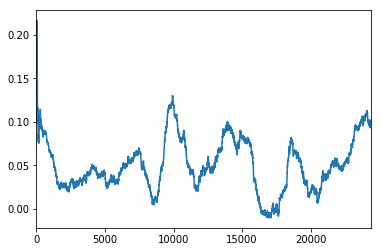

In [150]:
df_sen['roll_polarity'].plot()

In [87]:
df_sen

NameError: name 'df_sen' is not defined

# PART II: Comparison of religious texts